


# Analysing Human Movement Patterns and Counting in Diverse Environments using ``YOLOV8`` and ``Roboflow supervision``

---
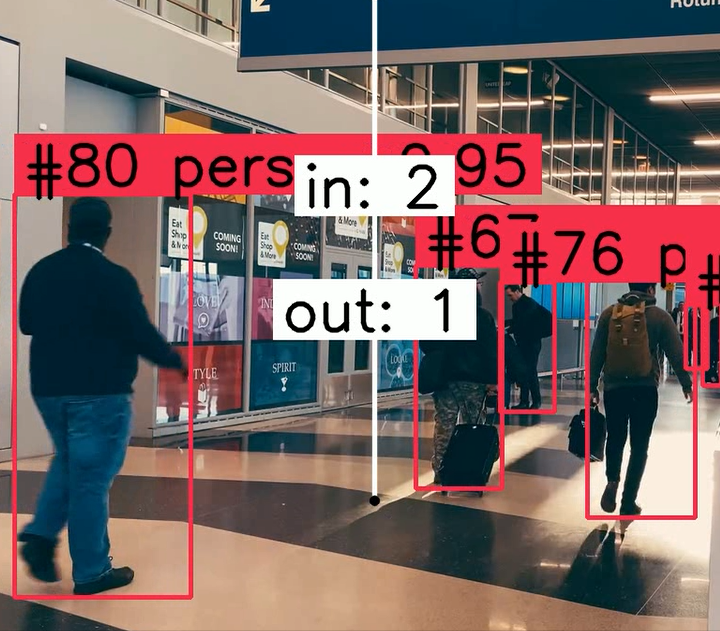
---

<a align="">
  <img width="600"src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png">
</a>

<a align="">
  <img width="600" src="https://camo.githubusercontent.com/8d64a0d2154d45961111842fff941b9f7ee5d822bb674e5366e50ea32f2bcbdc/68747470733a2f2f6d656469612e726f626f666c6f772e636f6d2f6f70656e2d736f757263652f7375706572766973696f6e2f72662d7375706572766973696f6e2d62616e6e65722e706e673f7570646174656441743d31363738393935393237353239">
</a>
<div align="center">
  <a href="https://github.com/ultralytics/ultralytics">
    <img src="https://github.com/ultralytics/hub/actions/workflows/ci.yaml/badge.svg" alt="CI CPU"></a>
  <a href="">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>





# Setup


Install `ultralytics` to Download, Train, Test, and Export Object detection models.

<a align="center">
  <img width="200" src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png">
</a>

In [ ]:
%pip install ultralytics  # install
from IPython import display
display.clear_output()

Install `roboflow` for datasets downloading

In [ ]:
%pip install roboflow
display.clear_output()

In [ ]:
import os
import shutil
import numpy as np
import yaml
from roboflow import Roboflow
from ultralytics import YOLO, checks, hub
checks()  # checks

Ultralytics YOLOv8.0.188 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/107.7 GB disk)


## Install Supervision

<a align="center">
  <img width ="300" src="https://camo.githubusercontent.com/8d64a0d2154d45961111842fff941b9f7ee5d822bb674e5366e50ea32f2bcbdc/68747470733a2f2f6d656469612e726f626f666c6f772e636f6d2f6f70656e2d736f757263652f7375706572766973696f6e2f72662d7375706572766973696f6e2d62616e6e65722e706e673f7570646174656441743d31363738393935393237353239">
</a>

In [ ]:
!pip install supervision==0.1.0
display.clear_output()

## Install ByteTrack



In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112
!pip install -q loguru lap

display.clear_output()



In [ ]:
!pip3 install thop
display.clear_output()

In [ ]:
import sys
sys.path.append(f"{HOME}/ByteTrack")
import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils



In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

# Import the model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from ultralytics import YOLO
model = YOLO("path\best.pt")  # load a pretrained model (recommended for training)

100%|██████████| 131M/131M [00:11<00:00, 11.5MB/s]


# Tracking and detection

In [ ]:
SOURCE_VIDEO_PATH='/content/pexels-kelly-3736783-3840x2160-24fps.mp4'

VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=24, total_frames=387)

In [ ]:
# settings
LINE_START = Point(1000, 0)
LINE_END = Point(1000, 2160)

TARGET_VIDEO_PATH = f"{HOME}/oussema-result.mp4"

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [i for i in range(80)]

In [ ]:
CLASS_NAMES_DICT

In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette.default(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame,classes=[0])
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/387 [00:00<?, ?it/s]


0: 384x640 20 persons, 29.2ms
Speed: 4.1ms preprocess, 29.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 15.6ms
Speed: 3.4ms preprocess, 15.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.7ms
Speed: 3.4ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 15.6ms
Speed: 3.4ms preprocess, 15.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.6ms
Speed: 4.2ms preprocess, 15.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 15.6ms
Speed: 3.6ms preprocess, 15.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.6ms
Speed: 3.8ms preprocess, 15.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 15.9ms
Speed: 4.2ms preprocess, 15.9ms inference, 2.3ms postprocess per image at

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -av '/content/ossema-result.mp4' "/content/drive/MyDrive/"

'/content/ossema-result.mp4' -> '/content/drive/MyDrive/ossema-result.mp4'
